# Abell 1656: the Coma Cluster of Galaxies
This notebook is based on the EURO-VO tutorial: "Abell 1656: The Coma Cluster of Galaxies" (http://www.euro-vo.org/?q=science/scientific-tutorials) and shows how to perform steps 1 to 8 from within a Jupyter notebook. Steps 9 to 11 are not implemented. 

## Introduction
The goals of this notebook tutorial are:
 - Examine the Coma cluster of galaxies (Abell 1656) using services and data from the virtual observatory withinin a jupyter notebook in order to perform a quick evaluation of the mean redshift and velocity dispersion of the cluster. Both measurements are important to study the evolution of galaxy clusters. 
 - Use redshifts and photometry (Petrosian r magnitude) of the SDSS survey and then add redshifts of the CAIRNS survey (Rines et al. 2003) in order to improve the completeness of the redshift sample.
 
For our analysis we need to following python packages:

In [1]:
import ipyaladin.aladin_widget as ipyal
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy.table import Table, vstack
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

## Display the region of Abell 1656 in Aladin lite
We start by displaying the Coma Cluster in an Aladin Lite widget. We will centre the DSS2 colour images (`survey='P/DSS2/color'`) on Abell 1656 (`target='A1656'`) and set the field of view to 0.7deg (`fov=0.7`). At the distance of Coma, our field of view corresponds to approximately 1Mpc a region large enough for our purposes. 

Note that if you are using Jupyter lab you can now open a second python3 notebook, click on the "Python 3" button in the top, right corner of this notebook to switch kernel. A new window will pop up and you can then select this notebook (i.e. "Abel1656...") as kernel. This will link the two notebooks such that they see the same variables ect. You may use the second linked notebook to be able to look at a Aladin Lite widget the entire time, while doing the analysis work in this notebook. Please see the ipyaladin webpage for more information on how to use the widget in Jupyter lab. 

In [2]:
aladin = ipyal.Aladin(target='A1656', fov=0.7, survey='P/DSS2/color')

In [3]:
aladin

Aladin(fov=0.7, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

As with any Aladin Lite implementation, you can interact with this widget: 
 - to zoom in and out place you mouse pointer on top of the image and scroll. 
 - with <img src="Images/ipyaladin_layer.png" alt="the Layer Button" style="width:30px; display: inline-block;"/>  you can select other image surveys and manage the current view.
 - if you like to look at another target, you can use the search field <img src="Images/ipyaladin_search.png" alt="the Search Button" style="width:30px; display: inline-block;"/> to get there. 

These interactions can also be steered by changing properties of the variable `aladin`. If for example, after zooming in and out, you wanted to set the FoV again to 0.7deg, do:

In [4]:
aladin.fov = 0.7

## Load the SDSS-DR9 catalog and select galaxies
In this section, we will search the SDSS DR9 catalogue at the VizieR catalogue service and then download all entries that are located within 40arcmin of the centre of the A1656. We start by querying VizieR for all catalogues that match the search term `SDSS DR9`: 

In [5]:
catalog_list_sdss = Vizier.find_catalogs('SDSS DR9')
for k, v in catalog_list_sdss.items():
    print(k, ': ', v.description)

II/336 :  AAVSO Photometric All Sky Survey (APASS) DR9 (Henden+, 2016)
V/139 :  The SDSS Photometric Catalog, Release 9 (Adelman-McCarthy+, 2012)
IX/48 :  Allsky cross-matched 3XMMe catalogue (Motch+, 2016)
J/A+A/547/L1 :  SDSS-III DR9 DLA catalogue (Noterdaeme+, 2012)
J/A+A/598/A92 :  New ultracool subdwarfs (Lodieu+, 2017)
J/A+A/616/A97 :  SDSS QSO DR7 and DR9 (D'Isanto+, 2018)
J/MNRAS/444/2456 :  Spectral galaxy pairs from SDSS DR9 (Yang+, 2014)
J/MNRAS/445/1331 :  White-dwarf + main-sequence binaries in SDSS DR9 (Li+, 2014)
J/MNRAS/450/905 :  New SNe in SDSS DR9 (Graur+, 2015)
J/MNRAS/458/3808 :  DR9-12 SDSS WDMS binaries (Rebassa-Mansergas+, 2016)
J/other/NewA/58.61 :  SDSS DR9 galaxy clusters optical catalog (Banerjee+, 2018)
J/other/RAA/17.62 :  Candidate members of 4 stellar streams (Li+, 2017)


We are interested in data from the main SDSS DR9 photometric catalogues: "The SDSS Photometric Catalog, Release 9 (Adelman-McCarthy+, 2012)". For an intial exploration of the content of this catalogue we do a query around 10arcmin of the centre of the Coma Cluster. We then print the output of the query, which is a list of Astropy Tables. 

In [6]:
results_test_sdss = Vizier.query_region("A1656", radius="0d10m0s", catalog='V/139')
print(results_test_sdss)

TableList with 1 tables:
	'0:V/139/sdss9' with 21 column(s) and 50 row(s) 


As you can see there is one table with 50 entries in our resulting list of tables, let's see which columns it contains:

In [7]:
print(results_test_sdss[0].colnames)

['mode', 'q_mode', 'cl', 'SDSS9', 'm_SDSS9', 'Im', 'RA_ICRS', 'DE_ICRS', 'ObsDate', 'Q', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp']


For our science target, we will only need the coordinates (`RA_ICRS` and `DE_ICRS`), r-band magnitudes (`rmag`) and redshifts (`zsp`) of the galaxies in the Coma cluster. Hence, we restrict our query such that we only get these columns. SDSS furthermore provides information on the type of source (galaxies: `cl` = 3) and observing mode (primary sources: `mode` = 1). To only get galaxies, which are also prinarmy sources, we implement a filtering of the columns. The way to implement these restrictions, is to create a specialiced instance of the Vizier class, which we will call v1.

In [8]:
v1 = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'rmag', 'zsp'],
            column_filters={'cl': '==3', 'mode': '==1'})

Above you might have noticed that the number of sources in the queried region is surprisingly small and round. This is because by default VizieR will only return 50 entries. If we want to get all sources within the queried region, we have to increase the `ROW_LIMIT`:

In [9]:
v1.ROW_LIMIT = -1

Now we that we have prepared everything, we can query VizieR for all galaxies, which are primary sources and within 40arcmin of the centre of the Coma cluster. Note that VizieR know that `A1656` is the centre of the Coma cluster. If you wanted to search at some other place in the sky, you could also give coordinates (in the form of Astropy's `SkyCoord`) instead of `'A1656'`.

In [10]:
results_coma_sdss = v1.query_region('A1656', radius='0d40m0s', catalog='V/139')
print(results_coma_sdss)

TableList with 1 tables:
	'0:V/139/sdss9' with 4 column(s) and 23771 row(s) 


As you can see, the result of our query includes data from one catalogue for 23771 objects (i.e. the table has 23771 rows). The output from this query is again a list of Astropy Table objects, so we assign the table to the variable `sdss_dr9` and work with this from here on. 

In [11]:
sdss_dr9 = results_coma_sdss[0]
sdss_dr9

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
194.569924,28.086985,22.478,--
194.570071,28.183590,22.929,--
194.570196,28.192751,20.766,--
194.570584,28.218809,22.314,--
194.570635,28.014748,22.166,--
194.571112,28.082954,20.126,--
194.571272,28.156997,23.555,--
194.571287,28.157763,22.653,--


## Identify the brightest sources as being stars contaminating the sample
We have already restricted our sample to sources that are classified as galaxies (`cl` = 3). However, for very bright sources, stars might be confused for galaxies. To test this and exclude any contamination from stars, we now take a closer look at the brightests sources. To do so we select sources brighter than 11.5 mag in r-band (`rmag < 11.5`) and check with the Aladin lite widget what these sources look like. 

In [12]:
stars = sdss_dr9[sdss_dr9['rmag'] < 11.5]
aladin.add_table(stars)
print('Our sample contains {} really bright sources.'.format(len(stars)))

Our sample contains 11 really bright sources.


With the line `aladin.add_table(stars)`, we have added symbols to the Aladin Lite widget at the location of the brightest sources (i.e. stars). If you now scroll back up to the Aladin Lite widget and zoom out, you will be able to find all the brightest sources. By looking at each source (zoom in on them), you will find that these are indeed stars. 

## Build a subset of galaxies with photometry and redshift in SDSS
Now on to exploring the galaxies in our sample. 
We again build a subset, this time for all sources fainter than 11.5mag (to leave out the stars identified in the section above) but brighter than 17.77mag, which is the completeness limit the SDSS spectroscopic sample. 

In [13]:
zsp17 = sdss_dr9[(sdss_dr9['rmag'] > 11.5) & (sdss_dr9['rmag'] < 17.77)]
zsp17

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
194.572522,28.040079,16.927,0.02065
194.575458,28.070532,17.258,0.15735
194.582202,28.094842,17.195,0.02392
194.590439,28.148753,14.516,0.02628
194.590959,27.967780,14.059,0.02005
194.592319,28.152134,15.193,0.02227
194.606369,28.128924,15.663,0.02736
194.625853,28.014753,13.784,0.02384


## Improve the completeness with other sources of redshifts in Vizier
As you can see in the table above, not all galaxies in our zsp17 sample have redshift measurements (some rows have '--' in the 'zsp' column, i.e. they are masked). So in order to improve the completeness of our sample we will now use Vizier to search for redshifts in the Rines et al (2003) catalogue. First find all catalogues that match the search terms 'redshifts Rines 2003':

In [14]:
catalog_list_rines = Vizier.find_catalogs('redshifts Rines 2003')
for k, v in catalog_list_rines.items():
    print(k, ': ', v.description)

J/AJ/124/1266 :  Redshift survey around Abell 2199 (Rines+, 2002)
J/AJ/126/2152 :  Cluster And Infall Region Nearby Survey. I (Rines+, 2003)


Of these two catalogues, we are interested in the 'J/AJ/126/2152' catalogue. So again, let's take a quick look at this catalogue. 

In [15]:
results_test_rines = Vizier.query_region("A1656", radius="0d10m0s", catalog='J/AJ/126/2152')
print(results_test_rines)

TableList with 2 tables:
	'0:J/AJ/126/2152/clusters' with 10 column(s) and 1 row(s) 
	'1:J/AJ/126/2152/galaxies' with 6 column(s) and 50 row(s) 


In [16]:
results_test_rines[0]

Cluster,n_Cluster,RAJ2000,DEJ2000,cz,sigmap_3s_,sigmap_ca_,LX,TX,R
,,"""h:m:s""","""d:m:s""",km / s,km / s,km / s,1e+36 W,keV,
bytes5,bytes1,bytes10,bytes9,int32,int16,int16,float32,float32,uint8
A1656,g,12 59 31.9,+27 54 10,6973,1042,957,18.0,8.0,2


In [17]:
results_test_rines[1]

RAJ2000,DEJ2000,cz,e_cz,r_cz,Cluster
"""h:m:s""","""d:m:s""",km / s,km / s,,
bytes11,bytes11,int32,int32,uint8,bytes5
12 59 03.85,+27 57 32.6,6978,6,2,A1656
12 59 05.83,+27 59 49.5,7699,27,1,A1656
12 59 09.43,+28 02 27.0,7220,31,2,A1656
12 59 11.51,+28 00 33.1,6942,30,2,A1656
12 59 13.00,+27 58 39.0,6747,64,1,A1656
12 59 13.83,+28 04 36.0,7805,28,1,A1656
12 59 14.36,+27 55 58.2,58669,75,2,A1656
12 59 14.61,+27 53 43.9,6450,21,2,A1656


After inspecting the result of the test query, it becomes clear that we are in particular interested in the 'galaxies' table of the catalogue. We aim to find redshifts in this table for galaxies, which have no SDSS redshifts. In a first step we divide the zsp17 sample into two subsamples: the ones that already have a redshift measurement - zsp17_with - and the ones without redshift measurements - zsp17_wihtout (the entry in the table is a NaN). Then we use the CDS XMatch service (http://cdsxmatch.u-strasbg.fr/) via the `astroquery.XMatch.query` module to look for spatial crossmatches of galaxies from the zsp17_wihtout sample with entries the 'J/AJ/126/2152/galaxies' table hosted at Vizier. 

In [18]:
ind = np.isnan(zsp17['zsp']) 
zsp17_with = zsp17[~ind]
zsp17_without = zsp17[ind]
zsp17_without.write('zsp17_without.csv', overwrite=True)
xmatch_sdss_rines = XMatch.query(cat1=open('zsp17_without.csv'), 
                                 cat2='vizier:J/AJ/126/2152/galaxies',
                                 max_distance=5 * u.arcsec, colRA1='RA_ICRS',
                                 colDec1='DE_ICRS')
xmatch_sdss_rines

angDist,RA_ICRS,DE_ICRS,rmag,zsp,_RAJ2000,_DEJ2000,recno,RAJ2000,DEJ2000,cz,e_cz,r_cz,Cluster
float64,float64,float64,float64,int64,float64,float64,int64,str11,str11,int64,int64,int64,str5
2.361441,194.804612,27.976975,15.824,--,194.8041667,27.9775,17334,12 59 13.00,+27 58 39.0,6747,64,1,A1656
4.507889,194.869572,28.085778,16.586,--,194.8683333,28.0851667,17403,12 59 28.40,+28 05 06.6,3650,100,2,A1656
2.489322,194.91736,28.179347,17.323,--,194.9165833,28.17925,17467,12 59 39.98,+28 10 45.3,5437,--,2,A1656
0.649338,195.044832,27.990943,14.771,--,195.04475,27.9907778,17612,13 00 10.74,+27 59 26.8,23078,41,2,A1656
0.843958,195.082099,28.121521,17.696,--,195.0818333,28.1215278,17653,13 00 19.64,+28 07 17.5,6659,65,2,A1656
0.546321,194.629479,27.895503,17.676,--,194.6293333,27.8955833,17154,12 58 31.04,+27 53 44.1,6804,83,2,A1656
1.346011,194.7349,27.803568,17.533,--,194.7349167,27.8031944,17262,12 58 56.38,+27 48 11.5,7864,64,2,A1656
2.674574,194.847414,27.911604,13.451,--,194.8466667,27.9119444,17381,12 59 23.20,+27 54 43.0,6899,31,1,A1656
0.284257,194.860237,27.856882,17.548,--,194.8601667,27.8568333,17397,12 59 26.44,+27 51 24.6,5007,75,2,A1656


## Build the final catalogue including the Rines et al. (2003) redshifts
The resulting table of the cross-match above contains 27 rows, so we have found recession velocity ('cz') measurements for 27 galaxies. Now let's add these data to the zsp17_with table.

In [19]:
zsp17_with['cz'] = zsp17_with['zsp'] * 300000
zsp17_without_new = xmatch_sdss_rines[zsp17_with.colnames]
zsp17_final = vstack([zsp17_with, zsp17_without_new])
zsp17_final

RA_ICRS,DE_ICRS,rmag,zsp,cz
deg,deg,mag,,
float64,float64,float64,float64,float64
194.572522,28.040079,16.927,0.02065,6195.000000000001
194.575458,28.070532,17.258,0.15735,47205.0
194.582202,28.094842,17.195,0.02392,7176.0
194.590439,28.148753,14.516,0.02628,7884.0
194.590959,27.967780,14.059,0.02005,6014.999999999999
194.592319,28.152134,15.193,0.02227,6681.000000000001
194.606369,28.128924,15.663,0.02736,8208.0
194.625853,28.014753,13.784,0.02384,7152.0


Now we have a table with all galaxies that have redshift measurements from SDSS and all additional galaxies, for which redshift measurements were obtained by Rines et al. (2003). Overall, the sample of galaxies within 40arcmin of the centre of the Coma cluster and with redshift measurements now contains 513 galaxies. Before we get started on the analysis of the data, we can have a look at the sources in the sample by loading the table into the Aladin Lite widget. They will appear in different colours than the stars before. 

In [24]:
aladin.add_table(zsp17_final)

## Determine the cz distribution, the cluster average velocity and velocity dispersion
Based on the 513 galaxies, we can now analyse the recession velocity and velocity dispersion of the Abell 1656 galaxy cluster. First we visualise the recession velocity distribution of the entire sample:

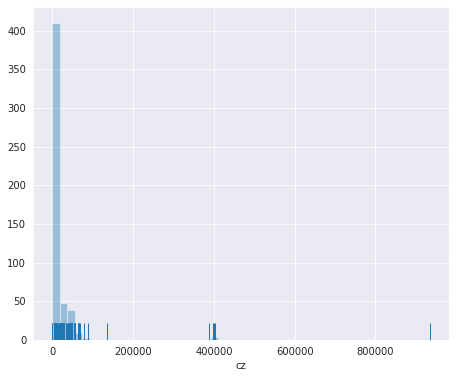

In [20]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(7.5, 6.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(zsp17_final['cz'], rug=True, ax=ax, kde=False)

Note how there is a large range of recession velocities in our sample. We are only interested in the range of recession velocities of the Coma cluster. These are around the large peak at low velocities. To focus on these, we restrict ourselves to recession velocities between 3000 and 11000 km/s. For easy analysis we first create the subsample `zsp17_coma` and then visualise the distribution of the recession velocity in this subsample:

(3000, 11000)

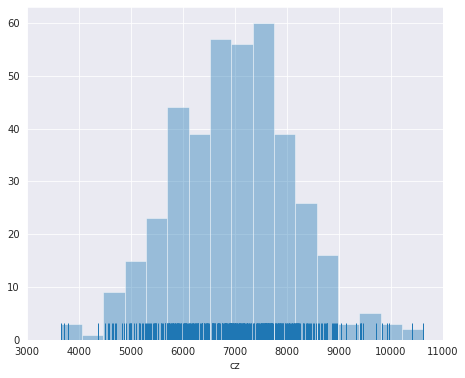

In [21]:
ind = (zsp17_final['cz'] > 3000.) & (zsp17_final['cz'] < 11000.)
zsp17_coma = zsp17_final[ind]

sns.set_style("darkgrid")
fig = plt.figure(figsize=(7.5, 6.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(zsp17_coma['cz'], rug=True, ax=ax, kde=False)
ax.set_xlim([3000, 11000])

These are data of all galaxies for which we collected redshift/recession velocity measurements and which are in the vincinity of the cluster (both spatially and in recession velocity). Now let's calculate the mean recession velocity of the cluster and its velocity dispersion:

In [22]:
print('The mean velocity in Coma is: {0:.1f}km/s and \
the standard deviation (i.e. velocity dispersion):\
{1:.1f}km/s'.format(np.mean(zsp17_coma['cz']), np.std(zsp17_coma['cz'])))

The mean velocity in Coma is: 6978.4km/s and the standard deviation (i.e. velocity dispersion):1138.9km/s


This is in agreement with more refined analyses (e.g. Sohn et al. 2017, ApJS, 229, 20). When looking back at the results of the query for the Rines et al. (2003) catalogue, you can also see that in their `clusters` table they gave `cz` = 6973km/s and `sigmap_3s_` = 1042km/s for the Coma cluster, again in good agreement with our result. 

In [23]:
results_test_rines[0]

Cluster,n_Cluster,RAJ2000,DEJ2000,cz,sigmap_3s_,sigmap_ca_,LX,TX,R
,,"""h:m:s""","""d:m:s""",km / s,km / s,km / s,1e+36 W,keV,
bytes5,bytes1,bytes10,bytes9,int32,int16,int16,float32,float32,uint8
A1656,g,12 59 31.9,+27 54 10,6973,1042,957,18.0,8.0,2
